# Head

In [52]:
import os
os.getcwd()

'/home/zqlyu2/projects'

In [53]:
import sys
sys.path.append("periodical-clustering")

from utils import get_data_dir

In [54]:
import os
import json
from tqdm import tqdm
import pickle

from utils import Scopus2abbr

import pandas as pd
import numpy as np
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import label_ranking_average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

class ProgressHashingVectorizer(HashingVectorizer):
    """带进度条的HashingVectorizer"""
    def transform(self, X):
        """重写transform方法以添加进度条"""
        # 如果输入是列表或类似列表的对象
        if hasattr(X, '__len__'):
            self.n_samples_ = len(X)
            # 创建包装器函数为文档添加进度条
            wrapped_X = tqdm(X, desc="Vectorizing documents", total=self.n_samples_)
            return super().transform(wrapped_X)
        # 如果输入不是列表类型（可能是生成器），则不添加进度条
        return super().transform(X)

class DocumentClassifier:
    def __init__(self, data_dir: str, model):
        self.data_dir = data_dir
        self.model = model
        self.vectorizer = None
        self.df = None
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.X_test = None
        self.X_train_OvR = None
        self.X_test_OvR = None
        self.label_to_method = {'kmeans_label': 'Periodical2Vec',
                                 # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                                 # 'movmf_label': 'Periodical2Vec+movMF',
                                 # 'bert_kmeans_label': 'BERT+$k$-means',
                                 'cm_n2v_kmeans_label': 'Citation+Node2Vec',
                                 'cocm_n2v_kmeans_label': 'Co-citation+Node2Vec',
                                 'cm_kmeans_label': 'Citation',
                                 'cocm_kmeans_label': 'Co-citation',
                                 # 'gnn_kmeans_label': 'GNN+$k$-means',
                                 'scopus_label': 'Scopus'}
        self.cv_models = {label: [] for label in self.label_to_method.keys()}
        self.roc_results = None
        self.cache_dir = os.path.join(data_dir, '2010s','cache') # 缓存文件路径
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def load_and_prepare_data(self, load_raw_abstract: bool=True) -> None:
        """加载abstracts和标签数据，构建DataFrame"""
        df_path = os.path.join(self.data_dir, '2010s/classification_tasks', 'df.parquet')
        if os.path.exists(df_path):
            print("Loading cached DataFrame...")
            self.df = pd.read_parquet(df_path)
            print(f"Loaded DataFrame with {len(self.df)} samples")
            return
        print("Loading abstracts and labels...")
        # 使用上下文管理器和生成器模式加载abstracts
        abstracts_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts.json')
        
        # 使用生成器表达式优化内存使用
        def abstract_generator(load_raw_abstract: True):
            with open(abstracts_path, 'r') as f:
                for line in tqdm(f, desc='Loading abstracts'):
                    try:
                        paper_data = json.loads(line.strip())
                        pid = str(paper_data['PaperID'])
                        if load_raw_abstract:
                            abstract = paper_data.get('abstract', '')
                            yield {'PaperID': pid, 'abstract': abstract}
                        else: # skip abstracts loading. No much speedup. Mainly for memory saving.
                            yield {'PaperID': pid}
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Error parsing JSON: {e}")
                        continue
                    
        print("Loading abstracts...")
        self.df = pd.DataFrame(abstract_generator(load_raw_abstract)) # 创建self.df
        self.df.set_index('PaperID', inplace=True)
        print(f"Initial DataFrame with {len(self.df)} abstracts")
        
        # 标签
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        labels_df = {}
        
        print("Processing label files...")
        for label_name in tqdm(self.label_to_method.keys(), desc='Labels processing'):
            label_file = f"{label_name}.json"
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as f:
                label_dict = json.load(f)
            labels_df[label_name] = {str(k): v for k, v in label_dict.items()} # ~45s for loading one label type
        labels_df = pd.DataFrame(labels_df)
        labels_df.index.name = 'PaperID'

        print(f"Labels DataFrame with {len(labels_df)} labels")
        print("Merging abstracts and labels...")
        self.df = self.df.join(labels_df, how='inner')
        print(f"Final dataset: {len(self.df)} valid samples")
    
    def prepare_features(self, df: pd.DataFrame, cv_fold_no: int = None, cache_type: str = None, test_ratio: float=0.2) -> np.ndarray:
        """集中处理文本特征提取逻辑，使用HashingVectorizer，加入缓存机制"""
        # 生成缓存文件路径
        if cv_fold_no is not None:
            cache_prefix = f"{cache_type}_hashing"
            features_cache_path = os.path.join(self.cache_dir, "cv", str(cv_fold_no), f"{cache_prefix}_features.npz")
            os.makedirs(os.path.dirname(features_cache_path), exist_ok=True)
        else:
            cache_prefix = f"{cache_type}_{test_ratio}_hashing"
            features_cache_path = os.path.join(self.cache_dir, "no_cv", f"{cache_prefix}_features.npz")
            os.makedirs(os.path.dirname(features_cache_path), exist_ok=True)
        
        # 检查是否存在缓存的特征
        print("feature cache path:", features_cache_path)
        if os.path.exists(features_cache_path):
            print(f"Loading cached Hashing features for {cache_type}...")
            X = sparse.load_npz(features_cache_path)
            return X
        else:
            print(f"No cached features found for {cache_type}. Proceeding to compute features...")
        
        # 如果没有缓存，则计算特征
        if self.vectorizer is None:
            print("Creating and applying HashingVectorizer...")
            self.vectorizer = ProgressHashingVectorizer(
                n_features=2**20,
                alternate_sign=False,
                stop_words='english',
                norm='l2',)
            X = self.vectorizer.fit_transform(df['abstract'])
        else:
            print("Applying existing HashingVectorizer...")
            X = self.vectorizer.transform(df['abstract'])
            print("Existing HashingVectorizer applied.")
        print(f"Caching Hashing features to {features_cache_path}")
        sparse.save_npz(features_cache_path, X)
        
        return X

    def train_model(self, label_name: str, cv_folds: int = None, test_ratio: float = 0.2):
        """训练特定标签的分类模型"""
        print(self.model)
        if self.df is None:
            raise ValueError("Dataset not loaded. Call load_and_prepare_data() first.")
        
        if cv_folds is not None: # 交叉验证训练
            print(f"Training model with {cv_folds}-fold cross-validation for label: {label_name}")
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
            self.cv_models[label_name] = [] # 初始化模型列表

            for fold, (train_index, test_index) in enumerate(kf.split(self.df)):
                print(f"Fold {fold + 1}/{cv_folds}")
                model_save_path = os.path.join(self.cache_dir, "cv", str(fold), f"{label_name}_model.pkl")
                os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
                if os.path.exists(model_save_path): # 检查模型是否已存在
                    print(f"Model for fold {fold + 1} already exists. Skipping training.")
                    with open(model_save_path, 'rb') as f:
                        model = pickle.load(f)
                    self.cv_models[label_name].append(model)
                    print(f"Loaded model for fold {fold + 1} from {model_save_path}")
                    continue
                else: # 如果模型不存在，则训练
                    train_df = self.df.iloc[train_index]
                    print(f"Model not exist. Start training a new one. Train set: {len(train_df)} samples")

                    # 特征提取，缓存训练特征
                    print("Preparing features for training data...")
                    X_train = self.prepare_features(train_df, fold, "train")

                    # 训练模型
                    print(f"Training model for label: {label_name}")
                    model = clone(self.model)
                    model.fit(X_train, train_df[label_name])
                    self.cv_models[label_name].append(model)
                    print("Model trained successfully")
                    # 缓存模型
                    with open(model_save_path, 'wb') as f:
                        pickle.dump(model, f)
                    print(f"Model for fold {fold + 1} saved to {model_save_path}")

        else:
            # 准备数据集
            if self.train_df is None and self.test_df is None:
                print("Splitting dataset into train and test sets...")
                self.train_df, self.test_df = train_test_split(
                    self.df, test_size=test_ratio, random_state=42)
                print(f"Train set: {len(self.train_df)} samples")
                print(f"Test set: {len(self.test_df)} samples")
            else:
                print("Using existing train and test sets")
            # 特征提取，缓存训练特征
            if self.X_train is None:
                print("Preparing features for training data...")
                self.X_train = self.prepare_features(self.train_df, "train")
            else:
                print("Using existing training features")
            print(f"Features shape: {self.X_train.shape}")

            # 训练模型
            print(f"Training model for label: {label_name}")
            self.model.fit(self.X_train, self.train_df[label_name])
            print("Model trained successfully")

            return self.model

    def evaluate_model(self, label_name: str, cv_folds: int = None, test_ratio: float = 0.1, 
                       baseline: bool = False, skip_rank = False):
        """评估模型性能，并与DummyClassifier进行对比"""
        unique_classes = sorted(self.df[label_name].unique()) # 注意：和label_name相关，Scopus标签数量多一个
        if cv_folds is not None:
            # 交叉验证评估
            print(f"Evaluating model with {cv_folds}-fold cross-validation for label: {label_name}")
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
            macro_cv_metrics = {'precision': [], 'recall': [], 'f1': []}
            weighted_cv_metrics = {'precision': [], 'recall': [], 'f1': []}
            cv_lrap = []
            cv_ranking_loss = []
            y_true_list = []
            y_pred_list = []

            for fold, (train_index, test_index) in enumerate(kf.split(self.df)):
                print(f"Fold {fold + 1}/{cv_folds}")
                test_df = self.df.iloc[test_index]
                print(f"Test set: {len(test_df)} samples")
                print("Preparing features for test data...")
                X_test = self.prepare_features(test_df, fold, "test", test_ratio)

                # 性能评估
                print("\nEvaluating model performance:")
                print("--------------------------------")
                y_true = test_df[label_name]
                y_pred = self.cv_models[label_name][fold].predict(X_test)
                y_true_list += y_true.to_list()
                y_pred_list += y_pred.tolist()

                # 单次评估
                macro_metrics = precision_recall_fscore_support(y_true, y_pred, average='macro')
                macro_precision, macro_recall, macro_f1, _ = macro_metrics
                macro_cv_metrics['precision'].append(macro_precision)
                macro_cv_metrics['recall'].append(macro_recall)
                macro_cv_metrics['f1'].append(macro_f1)
                print("macro precision: {:.4f}".format(macro_precision))
                print("macro recall: {:.4f}".format(macro_recall))
                print("macro f1: {:.4f}".format(macro_f1))

                weighted_metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
                weighted_precision, weighted_recall, weighted_f1, _ = weighted_metrics
                weighted_cv_metrics['precision'].append(weighted_precision)
                weighted_cv_metrics['recall'].append(weighted_recall)
                weighted_cv_metrics['f1'].append(weighted_f1)
                print("weighted precision: {:.4f}".format(weighted_precision))
                print("weighted recall: {:.4f}".format(weighted_recall))
                print("weighted f1: {:.4f}".format(weighted_f1))

                # ------------ label_ranking_loss 计算 ------------
                if skip_rank == False:
                    y_true_bin = label_binarize(y_true, classes=unique_classes)
                    y_score = self.cv_models[label_name][fold].predict_proba(X_test)
                    lrap = label_ranking_average_precision_score(y_true_bin, y_score)
                    ranking_loss = label_ranking_loss(y_true_bin, y_score)
                    cv_lrap.append(lrap)
                    cv_ranking_loss.append(ranking_loss)
                    print(f"Label ranking average precision: {lrap:.4f}")
                    print(f"Label ranking loss: {ranking_loss:.4f}")
                
                print("--------------------------------------------------\n")
            
            # 总结交叉验证结果
            mean_macro_metrics = {metric: np.mean(values) for metric, values in macro_cv_metrics.items()}
            std_macro_metrics = {metric: np.std(values) for metric, values in macro_cv_metrics.items()}
            mean_weighted_metrics = {metric: np.mean(values) for metric, values in weighted_cv_metrics.items()}
            std_weighted_metrics = {metric: np.std(values) for metric, values in weighted_cv_metrics.items()}
            mean_cv_lrap = np.mean(cv_lrap)
            std_cv_lrap = np.std(cv_lrap)
            mean_cv_ranking_loss = np.mean(cv_ranking_loss)
            std_cv_ranking_loss = np.std(cv_ranking_loss)
            print("\nCross-validation results:")
            print("--------------------------------")
            print(f"Macro precision: {mean_macro_metrics['precision']:.4f} ± {std_macro_metrics['precision']:.4f}")
            print(f"Macro recall: {mean_macro_metrics['recall']:.4f} ± {std_macro_metrics['recall']:.4f}")
            print(f"Macro F1: {mean_macro_metrics['f1']:.4f} ± {std_macro_metrics['f1']:.4f}")
            print(f"Weighted precision: {mean_weighted_metrics['precision']:.4f} ± {std_weighted_metrics['precision']:.4f}")
            print(f"Weighted recall: {mean_weighted_metrics['recall']:.4f} ± {std_weighted_metrics['recall']:.4f}")
            print(f"Weighted F1: {mean_weighted_metrics['f1']:.4f} ± {std_weighted_metrics['f1']:.4f}")
            # ----------------------------------------------------
            # 绘制混淆矩阵
            self._plot_confusion_matrices(y_true_list, y_pred_list, label_name=label_name)
            if skip_rank == False:
                print(f"Label ranking average precision: {mean_cv_lrap:.4f} ± {std_cv_lrap:.4f}")
                print(f"Label ranking loss: {mean_cv_ranking_loss:.4f} ± {std_cv_ranking_loss:.4f}")

        else: # 不做交叉验证
            print(self.model)
            if self.X_test is None:
                print("Preparing features for test data...")
                self.X_test = self.prepare_features(self.test_df, "test", test_ratio)
            
            # 性能评估
            print("\nEvaluating model performance:")
            print("--------------------------------")
            y_true = self.test_df[label_name]
            y_pred = self.model.predict(self.X_test)

            print(classification_report(y_true, y_pred, digits=4))
            
            model_metrics = precision_recall_fscore_support(
                y_true, y_pred, average='macro'
            )
            model_precision, model_recall, model_f1, _ = model_metrics

            # ------------ baseline performance 计算 ------------
            if baseline:
                # 基准模型评估
                print("\nEvaluating baseline model (Stratified Random):")
                print("------------------------------------------")
                baseline_model = DummyClassifier(strategy='stratified', random_state=42)
                baseline_model.fit(self.X_train, self.train_df[label_name])
                baseline_pred = baseline_model.predict(self.X_test)
                
                baseline_metrics = precision_recall_fscore_support(
                    y_true, baseline_pred, average='macro'
                )
                baseline_precision, baseline_recall, baseline_f1, _ = baseline_metrics
                
                # 性能改进报告
                print("\nImprovement over baseline (macro metrics):")
                print("----------------------------------------")
                metrics_diff = {
                    "Precision": model_precision - baseline_precision,
                    "Recall": model_recall - baseline_recall,
                    "F1": model_f1 - baseline_f1
                }
                for metric, diff in metrics_diff.items():
                    print(f"{metric} difference: {diff:.4f}")
            # ----------------------------------------------------
            # 绘制混淆矩阵
            self._plot_confusion_matrices(y_true, y_pred, baseline_pred, label_name, plot_baseline=baseline)

            # ------------ label_ranking_loss 计算 ------------
            y_true_bin = label_binarize(y_true, classes=unique_classes)
            y_score = self.model.predict_proba(self.X_test)
            lrap = label_ranking_average_precision_score(y_true_bin, y_score)
            ranking_loss = label_ranking_loss(y_true_bin, y_score)
            print(f"\nLabel ranking average precision: {lrap:.4f}")
            print(f"\nLabel ranking loss: {ranking_loss:.4f}")

    def _plot_confusion_matrices(self, y_true, y_pred, plot_baseline: bool = False, baseline_pred=None, label_name=None):
        """封装混淆矩阵绘制逻辑，根据label_name映射Scopus标签"""
        # 根据label_name决定类别标签
        if label_name == "scopus_label":
            # 从数据集中获取所有出现过的类别，保证标签顺序一致
            unique_labels = sorted(list(set(list(y_true) + list(y_pred))))
            # 使用缩写标签列表
            abbr_labels = [Scopus2abbr.get(lbl, lbl) for lbl in unique_labels]
        else:
            unique_labels = sorted(list(set(list(y_true) + list(y_pred))))
            abbr_labels = unique_labels

        if plot_baseline:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            cbar_ax = fig.add_axes([0.9, 0.06, 0.02, 0.88])
            
            # 模型混淆矩阵
            cm_model = confusion_matrix(y_true, y_pred, labels=unique_labels, normalize='true')
            sns.heatmap(cm_model, annot=False, cmap='Blues', vmin=0.2, vmax=1, ax=ax1, cbar=False,
                        xticklabels=abbr_labels, yticklabels=abbr_labels)
            ax1.set_title(f"Trained classifier")
            ax1.set_xlabel('Prediction')
            ax1.set_ylabel('Labels')
            
            # Baseline混淆矩阵
            cm_baseline = confusion_matrix(y_true, baseline_pred, labels=unique_labels, normalize='true')
            sns.heatmap(cm_baseline, annot=False, cmap='Blues', vmin=0.2, vmax=1, ax=ax2, 
                        cbar=True, cbar_ax=cbar_ax, xticklabels=abbr_labels, yticklabels=abbr_labels)
            ax2.set_title(f"Dummy classifier")
            ax2.set_xlabel('Prediction')
            ax2.set_ylabel('Labels')
        else:
            fig, ax1 = plt.subplots(figsize=(8, 6))
            
            # 模型混淆矩阵
            cm_model = confusion_matrix(y_true, y_pred, labels=unique_labels, normalize='true')
            sns.heatmap(cm_model, annot=False, cmap='Blues', vmin=0.2, vmax=1, cbar=True,
                        xticklabels=abbr_labels, yticklabels=abbr_labels)
            ax1.set_xlabel('Prediction')
            ax1.set_ylabel('Labels')

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        
        # 保存图像并显示
        output_path = os.path.join('periodical-clustering/tasks/doc_classification', 
                                f'confusion_matrix_{label_name}.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Confusion matrix saved to {output_path}")

    def one_vs_rest(self, label_to_method: dict, test_ratio: float = 0.2, metric: str = 'roc'):
        """修改后的One-vs-Rest分类实现，单次实验"""
        print("Current model:", self.model)
        if self.df is None:
            print("Dataset not loaded. Call load_and_prepare_data first.")
            self.load_and_prepare_data()
        
        # 初始化结果存储
        self.roc_results = {label: [] for label in label_to_method.keys()}
        self.pr_results = {label: [] for label in label_to_method.keys()}
        
        # 准备数据集
        if self.train_df is None and self.test_df is None:
            print("Splitting dataset into train and test sets...")
            self.train_df, self.test_df = train_test_split(
                self.df, test_size=test_ratio, random_state=42)
            print(f"Train set: {len(self.train_df)} samples")
            print(f"Test set: {len(self.test_df)} samples")
        else:
            print("Using existing train and test sets")
        # 特征提取，缓存训练特征
        if self.X_train_OvR is None:
            print("Preparing features for training data...")
            self.X_train_OvR = self.prepare_features(self.train_df, None, "train", test_ratio)
        else:
            print("Using existing training features")
            print(f"Training features shape: {self.X_train_OvR.shape}")
        if self.X_test_OvR is None:
            print("Preparing features for test data...")
            self.X_test_OvR = self.prepare_features(self.test_df, None, "test", test_ratio)
        else:
            print("Using existing test features")
            print(f"Test features shape: {self.X_test_OvR.shape}")
        
        # 处理每个标签
        for label_column, method_name in label_to_method.items():
            print(f"\nProcessing {method_name} ({label_column})")
            unique_classes = sorted(self.df[label_column].unique())
            y_train = label_binarize(self.train_df[label_column], classes=unique_classes)
            y_test = label_binarize(self.test_df[label_column], classes=unique_classes)
            n_classes = y_train.shape[1]
            
            # 训练模型
            print("Training classifier...")
            classifier = OneVsRestClassifier(self.model, n_jobs=-1, verbose=1)
            classifier.fit(self.X_train_OvR, y_train)
            
            # 模型评估
            print(f"Computing {metric} and AUC...")
            y_score = classifier.predict_proba(self.X_test_OvR)
            if metric == 'roc':
                fpr, tpr, macro_auc = self._compute_roc_metrics(y_test, y_score, n_classes)
                self.roc_results[label_column].append((fpr, tpr, macro_auc))
                print(f"{label_column}: Macro AUC = {macro_auc:.4f}")

            
            if metric == 'pr':
                recall, precision, macro_ap = self._compute_pr_metrics(y_test, y_score, n_classes)
                self.pr_results[label_column].append((recall, precision, macro_ap))
                print(f"{label_column}: Macro AP = {macro_ap:.4f}")
            
            if metric == 'both':
                fpr, tpr, macro_auc = self._compute_roc_metrics(y_test, y_score, n_classes)
                recall, precision, macro_ap = self._compute_pr_metrics(y_test, y_score, n_classes)
                self.roc_results[label_column].append((fpr, tpr, macro_auc))
                self.pr_results[label_column].append((recall, precision, macro_ap))
                print(f"{label_column}: Macro AUC = {macro_auc:.4f}, Macro AP = {macro_ap:.4f}")

        if metric == 'roc':
            with open(os.path.join(self.data_dir, '2010s', 'classification_tasks',f'{metric}_results.pkl'), 'wb') as f:
                pickle.dump(self.roc_results, f)
                print(f"{metric} results saved to {metric}_results.pkl")
                return self.roc_results
        
        if metric == 'pr':
            with open(os.path.join(self.data_dir, '2010s', 'classification_tasks',f'{metric}_results.pkl'), 'wb') as f:
                pickle.dump(self.pr_results, f)
                print(f"{metric} results saved to {metric}_results.pkl")
                return self.pr_results
        
        if metric == 'both':
            with open(os.path.join(self.data_dir, '2010s', 'classification_tasks',f'roc_results.pkl'), 'wb') as f:
                pickle.dump(self.roc_results, f)
                print(f"{metric} results saved to roc_results.pkl")
            with open(os.path.join(self.data_dir, '2010s', 'classification_tasks',f'pr_results.pkl'), 'wb') as f:
                pickle.dump(self.pr_results, f)
                print(f"{metric} results saved to pr_results.pkl")
            return self.roc_results, self.pr_results

    def _compute_roc_metrics(self, y_test, y_score, n_classes):
        """ROC计算"""
        fpr = dict()
        tpr = dict()
        
        # 对每个类别计算ROC
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        
        # 宏平均ROC曲线
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        
        return all_fpr, mean_tpr, macro_auc
    
    def _compute_pr_metrics(self, y_test, y_score, n_classes):
        """计算PR曲线相关指标"""
        precision = dict()
        recall = dict()
        average_precision = dict()
        
        # 逐类别计算
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        
        # 宏平均PR曲线
        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)
        
        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
        
        mean_precision /= n_classes
        macro_ap = np.mean(list(average_precision.values()))
        
        return all_recall, mean_precision, macro_ap

# Initialize

In [55]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

data_dir = get_data_dir()
model = ComplementNB()
# model = MultinomialNB()
# model = RandomForestClassifier(random_state=42, n_jobs=-1)
# model = SGDClassifier(loss='log_loss', early_stopping=True, random_state=42, 
#                       n_jobs=-1, verbose=0)

classifier = DocumentClassifier(data_dir, model)

data_dir:  /home/zqlyu2/projects/periodical-clustering/data


In [10]:
classifier.load_and_prepare_data()
classifier.df

Loading cached DataFrame...
Loaded DataFrame with 23322430 samples


,abstract,kmeans_label,cm_n2v_kmeans_label,cocm_n2v_kmeans_label,cm_kmeans_label,cocm_kmeans_label,scopus_label
PaperID,,,,,,,
2055207701,Abstract Lake Trout Salvelinus namaycush were ...,8,2,11,1,25,Agricultural and Biological Sciences
2055207717,Background\r\n\r\nThere is an increasing inter...,7,1,11,23,16,Medicine
2055207742,The primary goal of the current study was to e...,23,25,2,1,1,Social Sciences
2055207772,Introduction Les tumeurs du tronc cerebral r...,22,10,2,7,15,Medicine
2055207790,"Matrix metalloproteinase-13 (MMP-13), referred...",16,20,11,4,8,Immunology and Microbiology
...,...,...,...,...,...,...,...
2726882176,Objective \r\nThe purpose of this study was to...,17,3,8,21,8,Multidisciplinary
2726882179,Abstract The notion of Corporate Social Re...,24,22,2,1,12,Social Sciences
2726882219,"In this paper, the possibility of improving th...",14,4,5,6,23,Materials Science


In [5]:
classifier.load_and_prepare_data(load_raw_abstract=False) # load labels only. No much speedup. Mainly for memory saving.
classifier.df

Loading abstracts and labels...
Loading abstracts...


Loading abstracts: 23322430it [01:53, 204588.80it/s]


Initial DataFrame with 23322430 abstracts
Processing label files...


Labels processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:07<00:00, 41.26s/it]


Labels DataFrame with 29309324 labels
Merging abstracts and labels...
Final dataset: 23322430 valid samples


,kmeans_label,cm_n2v_kmeans_label,cocm_n2v_kmeans_label,cm_kmeans_label,cocm_kmeans_label,scopus_label
PaperID,,,,,,
2055207701,8,2,11,1,25,Agricultural and Biological Sciences
2055207717,7,1,11,23,16,Medicine
2055207742,23,19,2,1,1,Social Sciences
2055207772,22,10,2,7,15,Medicine
2055207790,16,20,11,4,8,Immunology and Microbiology
...,...,...,...,...,...,...
2726882176,17,3,8,21,8,Multidisciplinary
2726882179,24,22,2,1,12,Social Sciences
2726882219,14,4,5,6,23,Materials Science


In [33]:
classifier.df.to_parquet(os.path.join(data_dir, '2010s/classification_tasks', 'df.parquet'))

In [6]:
from sklearn.linear_model import LogisticRegression

# a chance to change model
classifier.model = LogisticRegression(random_state=42, verbose=0)

In [41]:
classifier.model

ComplementNB()

# Multi-class classification

## No cross-validation

In [11]:
model = classifier.train_model('kmeans_label')

ComplementNB()
Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Preparing features for training data...
Loading cached Hashing features for train...
Features shape: (18657944, 1048576)
Training model for label: kmeans_label
Model trained successfully


ComplementNB()
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.6233    0.3958    0.4842     49276
           1     0.5603    0.2206    0.3166     91678
           2     0.3926    0.0405    0.0733     51072
           3     0.7370    0.4737    0.5767    108366
           4     0.6589    0.5179    0.5799    261865
           5     0.4931    0.6859    0.5737    170742
           6     0.7116    0.6432    0.6757    322725
           7     0.5275    0.6985    0.6011    391338
           8     0.6551    0.6455    0.6502    151812
           9     0.5938    0.6089    0.6013    176703
          10     0.6923    0.0019    0.0038     61370
          11     0.6563    0.8415    0.7374    565791
          12     0.6640    0.6244    0.6436    193110
          13     0.4348    0.7498    0.5504     59157
          14     0.6407    0.5

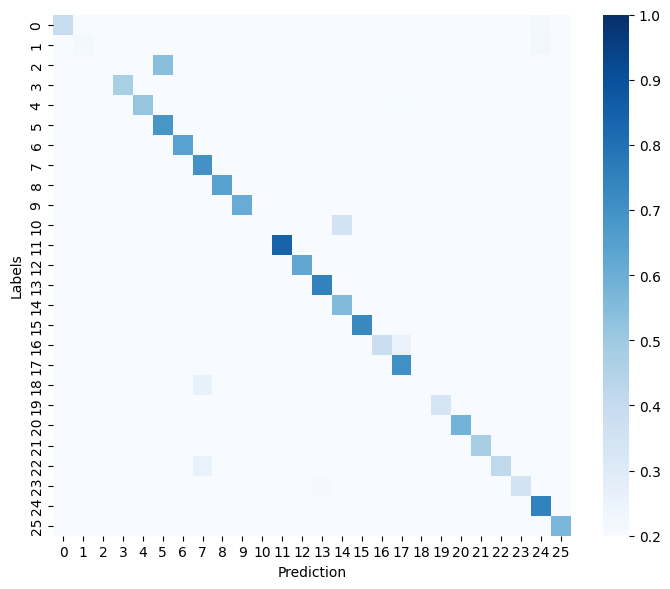

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_kmeans_label.pdf

Label ranking loss: 0.7447

Label ranking loss: 0.0550


In [12]:
classifier.evaluate_model('kmeans_label', plot_baseline=False)

In [13]:
model = classifier.train_model('n2v_kmeans_label')

ComplementNB()
Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: n2v_kmeans_label
Model trained successfully


ComplementNB()

Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.5434    0.0073    0.0144     43697
           1     0.4262    0.6483    0.5143    244706
           2     0.5271    0.6156    0.5679    233948
           3     0.4287    0.0874    0.1452    356307
           4     0.5555    0.8717    0.6786    661279
           5     0.6561    0.0143    0.0281      8645
           6     0.4211    0.2135    0.2834     62781
           7     0.5475    0.0129    0.0253    244657
           8     0.4886    0.4409    0.4635     51745
           9     0.5499    0.5469    0.5484    168470
          10     0.4792    0.0217    0.0415    175568
          11     0.5634    0.0499    0.0917     16820
          12     0.5549    0.5953    0.5744    282398
          13     0.2978    0.0888    0.1369     83091
          14     0.4927    0.0241    0.0459    165877
          15     0.3268    0.0675    0.1119    114171
  

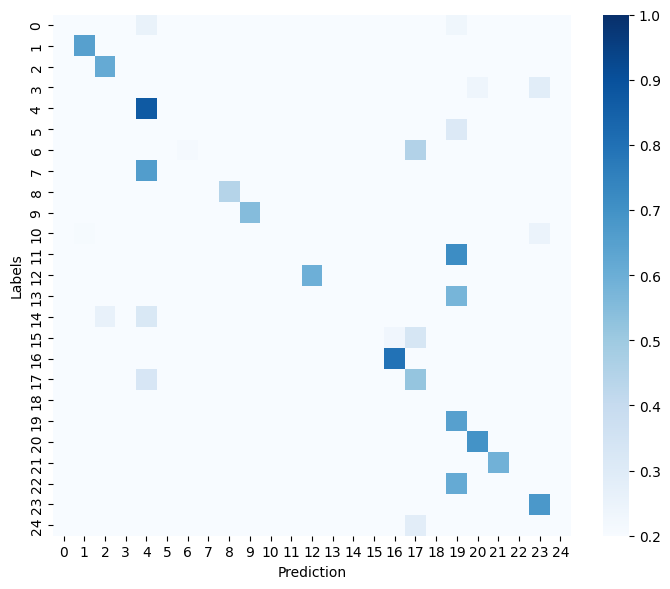

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_n2v_kmeans_label.pdf

Label ranking loss: 0.6527

Label ranking loss: 0.0834


In [14]:
classifier.evaluate_model('n2v_kmeans_label', plot_baseline=False)

In [15]:
model = classifier.train_model('cm_kmeans_label')

ComplementNB()
Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: cm_kmeans_label
Model trained successfully


ComplementNB()

Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.5187    0.5572    0.5372    138108
           1     0.6050    0.5806    0.5926    998705
           2     0.6875    0.0015    0.0030      7236
           3     0.5731    0.4371    0.4959    139119
           4     0.6187    0.6179    0.6183    386303
           5     0.5767    0.1229    0.2026     32867
           6     0.5863    0.4810    0.5285    361072
           7     0.6272    0.4006    0.4889     77339
           8     0.6498    0.6218    0.6355    137356
           9     0.7685    0.1357    0.2306     10569
          10     0.6124    0.5485    0.5787     60314
          11     0.6405    0.1149    0.1949     49417
          12     0.5862    0.0044    0.0087      3878
          13     0.5878    0.5890    0.5884     92324
          14     0.6532    0.4840    0.5560    217639
          15     0.7257    0.6720    0.6978     26577
  

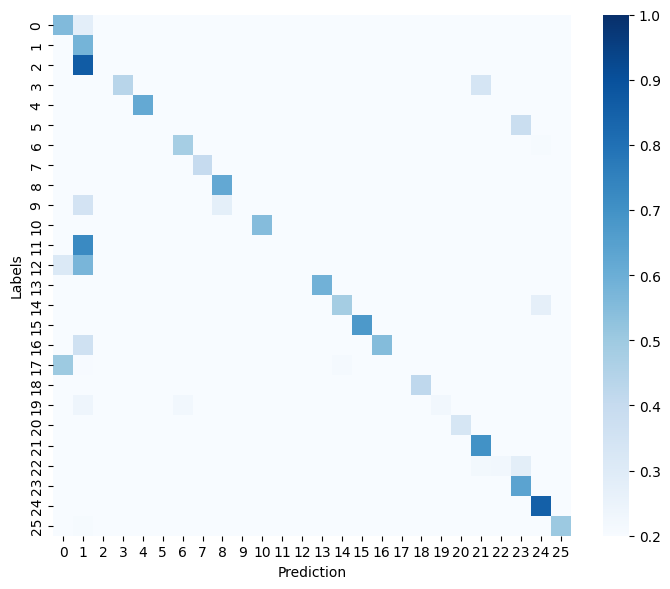

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cm_kmeans_label.pdf

Label ranking loss: 0.7216

Label ranking loss: 0.0852


In [16]:
classifier.evaluate_model('cm_kmeans_label', plot_baseline=False)

In [15]:
model = classifier.train_model('cocm_kmeans_label')

ComplementNB()
Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Preparing features for training data...
Loading cached Hashing features for train...
Features shape: (18657944, 1048576)
Training model for label: cocm_kmeans_label
Model trained successfully


ComplementNB()
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.6263    0.8197    0.7101     94349
           1     0.6353    0.5358    0.5813    180859
           2     0.5695    0.4347    0.4931    161254
           3     0.7360    0.0160    0.0314     16330
           4     0.6311    0.4457    0.5224     78864
           5     0.7105    0.4114    0.5211    109468
           6     0.5826    0.5355    0.5581    252154
           7     0.5372    0.3894    0.4515    106547
           8     0.6541    0.7393    0.6941    847866
           9     0.5784    0.3141    0.4071    128923
          10     0.6506    0.3443    0.4503    151712
          11     0.7445    0.1577    0.2603     22504
          12     0.5490    0.7230    0.6241    130160
          13     0.4684    0.7780    0.5848    119778
          14     0.8299    0.1

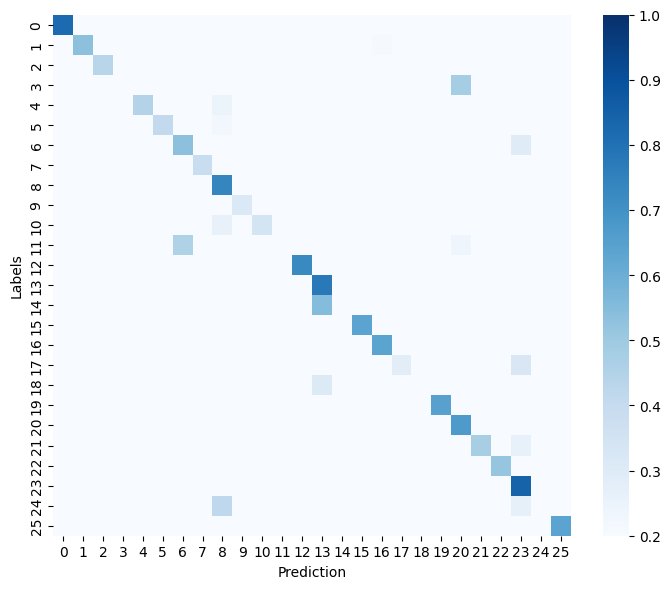

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cocm_kmeans_label.pdf

Label ranking average precision: 0.7443

Label ranking loss: 0.0599


In [16]:
classifier.evaluate_model('cocm_kmeans_label', plot_baseline=False)

In [17]:
model = classifier.train_model('scopus_label')

ComplementNB()
Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: scopus_label
Model trained successfully


ComplementNB()

Evaluating model performance:
--------------------------------
                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences     0.5835    0.7866    0.6700    278826
                         Arts and Humanities     0.6973    0.3339    0.4516     81809
Biochemistry, Genetics and Molecular Biology     0.4570    0.4281    0.4421    252561
         Business, Management and Accounting     0.6143    0.2822    0.3867     61449
                        Chemical Engineering     0.6869    0.0170    0.0332     61802
                                   Chemistry     0.5372    0.6721    0.5971    273941
                            Computer Science     0.5551    0.2112    0.3060    112889
                           Decision Sciences     0.7018    0.0036    0.0072     10987
                                   Dentistry     0.6677    0.1835    0.2879     26883
                Earth and Planetary Sciences     0.6766    0

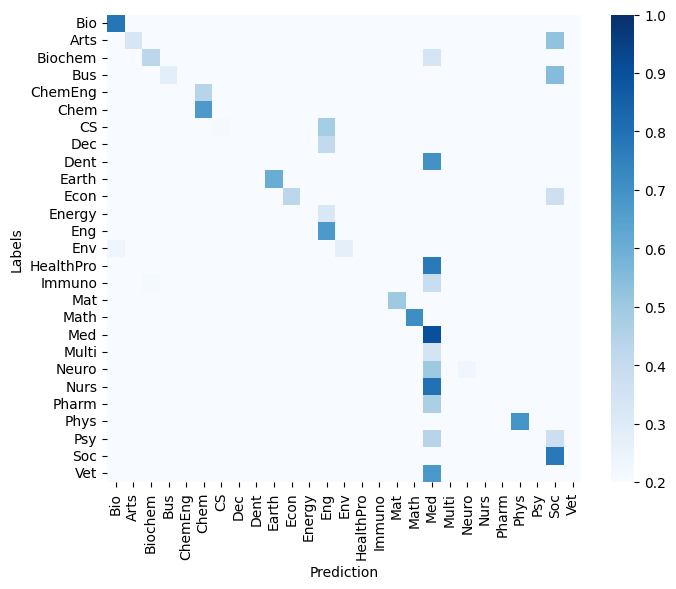

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_scopus_label.pdf

Label ranking loss: 0.7406

Label ranking loss: 0.0574


In [18]:
classifier.evaluate_model('scopus_label', plot_baseline=False)

## 10-fold cross-validation

In [35]:
classifier.model = ComplementNB()
classifier.train_model('kmeans_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: kmeans_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/kmeans_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/kmeans_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/kmeans_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/kmeans_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/4/kmeans_label_model.pkl
Fold 6/10
Model 

In [26]:
classifier.cv_models['kmeans_label'][-1]

ComplementNB()

Evaluating model with 10-fold cross-validation for label: kmeans_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6049
macro recall: 0.5059
macro f1: 0.5165
weighted precision: 0.6117
weighted recall: 0.6037
weighted f1: 0.5881
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6070
macro recall: 0.5064
macro f1: 0.5170
weighted precision: 0.6128
weighted recall: 0.6044
weighted f1: 0.5887
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.

/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


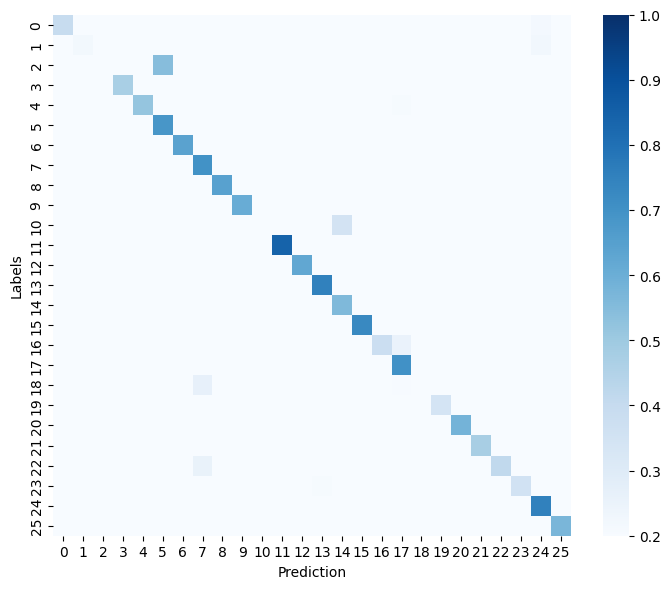

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_kmeans_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [36]:
classifier.evaluate_model('kmeans_label', 10, skip_rank=True)

In [37]:
classifier.model = ComplementNB()
classifier.train_model('cm_n2v_kmeans_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: cm_n2v_kmeans_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/cm_n2v_kmeans_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/cm_n2v_kmeans_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/cm_n2v_kmeans_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/cm_n2v_kmeans_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/4/cm_n

Evaluating model with 10-fold cross-validation for label: cm_n2v_kmeans_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.4589
macro recall: 0.3322
macro f1: 0.3116
weighted precision: 0.4715
weighted recall: 0.4781
weighted f1: 0.4147
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.4628
macro recall: 0.3326
macro f1: 0.3120
weighted precision: 0.4705
weighted recall: 0.4784
weighted f1: 0.4149
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precis

/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


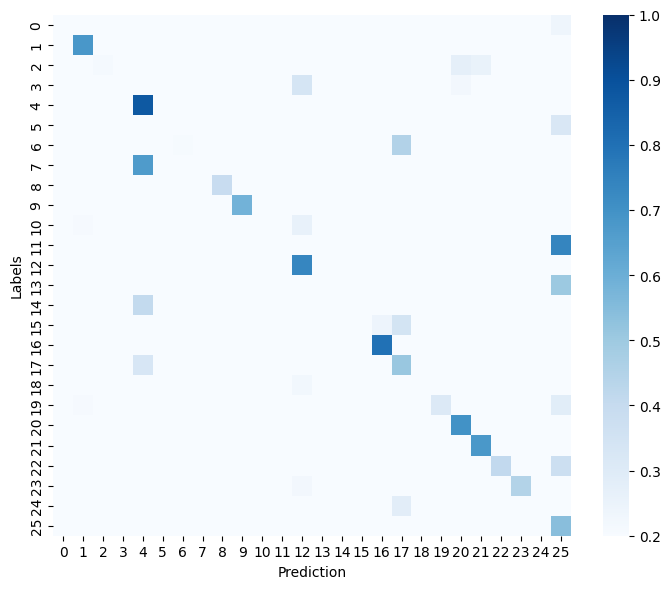

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cm_n2v_kmeans_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [38]:
classifier.evaluate_model('cm_n2v_kmeans_label', 10, skip_rank=True)

In [39]:
classifier.model = ComplementNB()
classifier.train_model('cocm_n2v_kmeans_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: cocm_n2v_kmeans_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/cocm_n2v_kmeans_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/cocm_n2v_kmeans_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/cocm_n2v_kmeans_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/cocm_n2v_kmeans_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache

Evaluating model with 10-fold cross-validation for label: cocm_n2v_kmeans_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3535
macro recall: 0.1249
macro f1: 0.1273


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5915
weighted recall: 0.6084
weighted f1: 0.5727
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3820
macro recall: 0.1247
macro f1: 0.1271


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5950
weighted recall: 0.6084
weighted f1: 0.5728
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3758
macro recall: 0.1246
macro f1: 0.1267


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5919
weighted recall: 0.6081
weighted f1: 0.5724
--------------------------------------------------

Fold 4/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3994
macro recall: 0.1253
macro f1: 0.1279


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5961
weighted recall: 0.6084
weighted f1: 0.5726
--------------------------------------------------

Fold 5/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.4127
macro recall: 0.1248
macro f1: 0.1270


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5996
weighted recall: 0.6084
weighted f1: 0.5729
--------------------------------------------------

Fold 6/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3675
macro recall: 0.1250
macro f1: 0.1275


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5925
weighted recall: 0.6087
weighted f1: 0.5730
--------------------------------------------------

Fold 7/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.3860
macro recall: 0.1253
macro f1: 0.1280
weighted precision: 0.5959
weighted recall: 0.6089
weighted f1: 0.5733
--------------------------------------------------

Fold 8/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3757
macro recall: 0.1253
macro f1: 0.1279


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.5950
weighted recall: 0.6090
weighted f1: 0.5732
--------------------------------------------------

Fold 9/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.4281
macro recall: 0.1256
macro f1: 0.1284


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


weighted precision: 0.6020
weighted recall: 0.6086
weighted f1: 0.5730
--------------------------------------------------

Fold 10/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


macro precision: 0.3760
macro recall: 0.1253
macro f1: 0.1277


/home/zqlyu2/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in div

weighted precision: 0.5929
weighted recall: 0.6090
weighted f1: 0.5733
--------------------------------------------------


Cross-validation results:
--------------------------------
Macro precision: 0.3857 ± 0.0209
Macro recall: 0.1251 ± 0.0003
Macro F1: 0.1275 ± 0.0005
Weighted precision: 0.5952 ± 0.0032
Weighted recall: 0.6086 ± 0.0003
Weighted F1: 0.5729 ± 0.0003


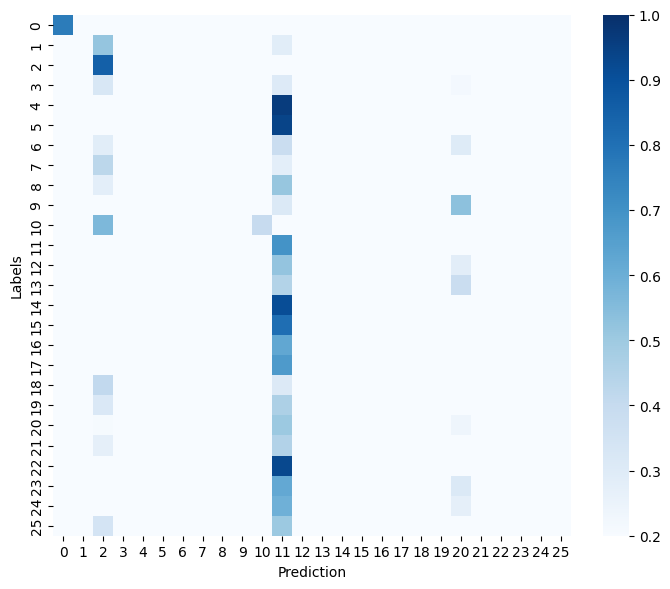

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cocm_n2v_kmeans_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [40]:
classifier.evaluate_model('cocm_n2v_kmeans_label', 10, skip_rank=True)

In [41]:
classifier.model = ComplementNB()
classifier.train_model('cocm_kmeans_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: cocm_kmeans_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/cocm_kmeans_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/cocm_kmeans_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/cocm_kmeans_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/cocm_kmeans_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/4/cocm_kmeans_la

Evaluating model with 10-fold cross-validation for label: cocm_kmeans_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6272
macro recall: 0.4746
macro f1: 0.4907
weighted precision: 0.6110
weighted recall: 0.6037
weighted f1: 0.5874
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6316
macro recall: 0.4747
macro f1: 0.4909
weighted precision: 0.6116
weighted recall: 0.6040
weighted f1: 0.5876
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precisio

/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


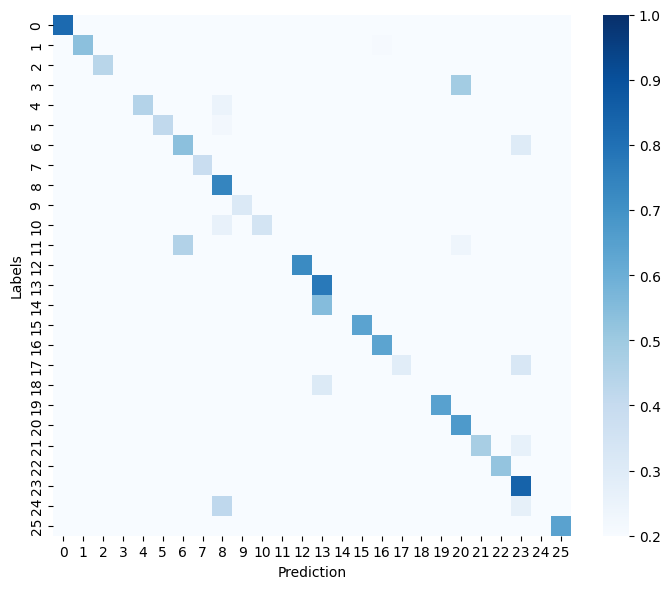

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cocm_kmeans_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [42]:
classifier.evaluate_model('cocm_kmeans_label', 10, skip_rank=True)

In [43]:
classifier.model = ComplementNB()
classifier.train_model('cm_kmeans_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: cm_kmeans_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/cm_kmeans_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/cm_kmeans_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/cm_kmeans_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/cm_kmeans_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/4/cm_kmeans_label_model.pk

Evaluating model with 10-fold cross-validation for label: cm_kmeans_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6048
macro recall: 0.4168
macro f1: 0.4429
weighted precision: 0.5853
weighted recall: 0.5786
weighted f1: 0.5690
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6150
macro recall: 0.4164
macro f1: 0.4423
weighted precision: 0.5855
weighted recall: 0.5784
weighted f1: 0.5687
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision:

/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


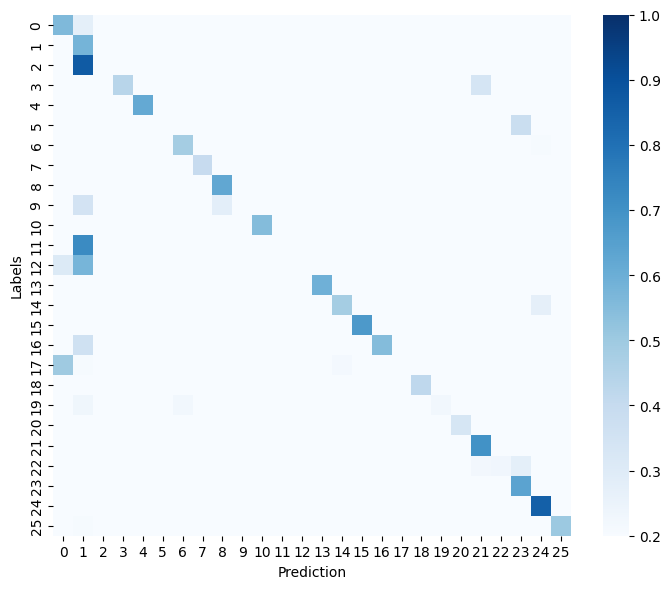

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_cm_kmeans_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [44]:
classifier.evaluate_model('cm_kmeans_label', 10, skip_rank=True)

In [45]:
classifier.model = ComplementNB()
classifier.train_model('scopus_label', 10)

ComplementNB()
Training model with 10-fold cross-validation for label: scopus_label
Fold 1/10
Model for fold 1 already exists. Skipping training.
Loaded model for fold 1 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/0/scopus_label_model.pkl
Fold 2/10
Model for fold 2 already exists. Skipping training.
Loaded model for fold 2 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/1/scopus_label_model.pkl
Fold 3/10
Model for fold 3 already exists. Skipping training.
Loaded model for fold 3 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/2/scopus_label_model.pkl
Fold 4/10
Model for fold 4 already exists. Skipping training.
Loaded model for fold 4 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/3/scopus_label_model.pkl
Fold 5/10
Model for fold 5 already exists. Skipping training.
Loaded model for fold 5 from /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/cv/4/scopus_label_model.pkl
Fold 6/10
Model 

Evaluating model with 10-fold cross-validation for label: scopus_label
Fold 1/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6077
macro recall: 0.3441
macro f1: 0.3628
weighted precision: 0.6135
weighted recall: 0.6017
weighted f1: 0.5587
--------------------------------------------------

Fold 2/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.6126
macro recall: 0.3443
macro f1: 0.3630
weighted precision: 0.6140
weighted recall: 0.6025
weighted f1: 0.5596
--------------------------------------------------

Fold 3/10
Test set: 2332243 samples
Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
macro precision: 0.

/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zqlyu2/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


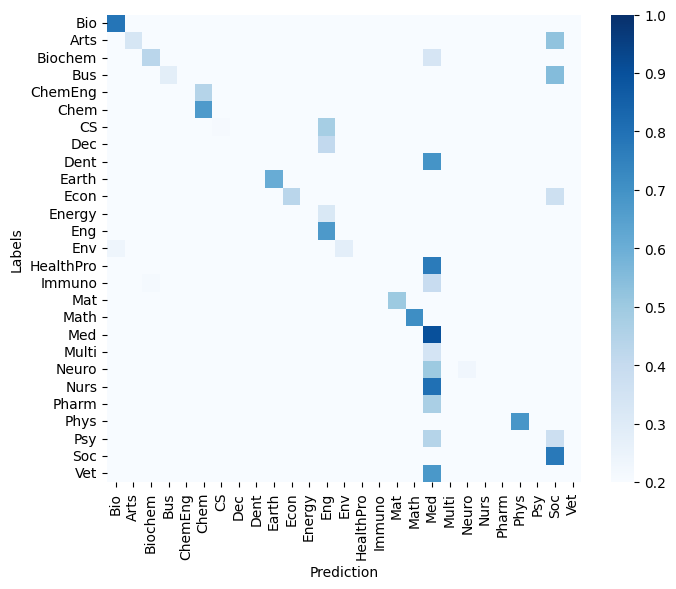

Confusion matrix saved to periodical-clustering/tasks/doc_classification/confusion_matrix_scopus_label.pdf
Label ranking average precision: nan ± nan
Label ranking loss: nan ± nan


In [46]:
classifier.evaluate_model('scopus_label', 10, skip_rank=True)

# One-vs-rest clasiification

In [12]:
# indicate the label we want to analyze
label_to_method = {'kmeans_label': 'Periodical2Vec',
                   # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                   # 'movmf_label': 'Periodical2Vec+movMF',
                   
                   # 'bert_kmeans_label': 'BERT+$k$-means',
                   'cm_kmeans_label': 'Citation',
                   'cm_n2v_kmeans_label': 'Citation+Node2Vec',
                   'cocm_kmeans_label': 'Co-citation',
                   'cocm_n2v_kmeans_label': 'Co-citation+Node2Vec',
                   # 'gnn_kmeans_label': 'GNN+$k$-means',
                   'scopus_label': 'Scopus'
                   }

In [13]:
roc_results, pr_results = classifier.one_vs_rest(label_to_method, metric='both')

Current model: ComplementNB()
Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Preparing features for training data...
feature cache path: /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/no_cv/train_0.2_hashing_features.npz
Loading cached Hashing features for train...
Preparing features for test data...
feature cache path: /home/zqlyu2/projects/periodical-clustering/data/2010s/cache/no_cv/test_0.2_hashing_features.npz
Loading cached Hashing features for test...

Processing Periodical2Vec (kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.5min finished


Computing both and AUC...
kmeans_label: Macro AUC = 0.9483, Macro AP = 0.4093

Processing Citation (cm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.4min finished


Computing both and AUC...
cm_kmeans_label: Macro AUC = 0.9426, Macro AP = 0.3348

Processing Citation+Node2Vec (cm_n2v_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.4min finished


Computing both and AUC...
cm_n2v_kmeans_label: Macro AUC = 0.9060, Macro AP = 0.2867

Processing Co-citation (cocm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.4min finished


Computing both and AUC...
cocm_kmeans_label: Macro AUC = 0.9501, Macro AP = 0.4036

Processing Co-citation+Node2Vec (cocm_n2v_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.4min finished


Computing both and AUC...
cocm_n2v_kmeans_label: Macro AUC = 0.8519, Macro AP = 0.1346

Processing Scopus (scopus_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.4min remaining:   59.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.5min finished


Computing both and AUC...
scopus_label: Macro AUC = 0.9379, Macro AP = 0.3398
both results saved to both_results.pkl
both results saved to both_results.pkl


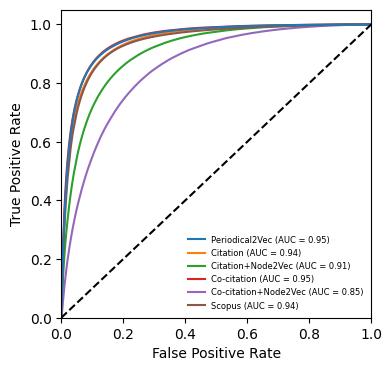

In [56]:
try:
    with open('/home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/roc_results.pkl', 'rb') as f:
        roc_results = pickle.load(f)
except FileNotFoundError:
    pass

fig = plt.figure(figsize=(4,4))
# 按照label_to_method中的顺序重新排序roc_results
for label, results in roc_results.items():
    for fpr, tpr, auc_score in results:
        if label == 'kmeans_label':
            z_order = 1
        else :
            z_order = 0
        plt.plot(fpr, tpr, label=f"{classifier.label_to_method[label]} (AUC = {auc_score:.2f})", zorder=z_order)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=6, frameon=False)

plt.show()

In [ ]:
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/doc_classificcation/roc_curve.pdf', dpi=300, bbox_inches='tight')

In [19]:
pr_results = classifier.one_vs_rest(label_to_method, metric='pr')

Current model: ComplementNB()
Using existing train and test sets
Using existing training features
Training features shape: (18657944, 1048576)
Using existing test features
Test features shape: (4664486, 1048576)

Processing Periodical2Vec+$k$-means (kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.1min finished


Computing pr and AUC...
kmeans_label: Macro AP = 0.4093

Processing Node2Vec+$k$-means (n2v_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


Computing pr and AUC...
n2v_kmeans_label: Macro AP = 0.3009

Processing Citation Matrix+$k$-means (cm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.1min finished


Computing pr and AUC...
cm_kmeans_label: Macro AP = 0.3348

Processing Co-citation Matrix+$k$-means (cocm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.1min finished


Computing pr and AUC...
cocm_kmeans_label: Macro AP = 0.4036

Processing Scopus (scopus_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.1min remaining:   45.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.1min finished


Computing pr and AUC...
scopus_label: Macro AP = 0.3398
pr results saved to pr_results.pkl


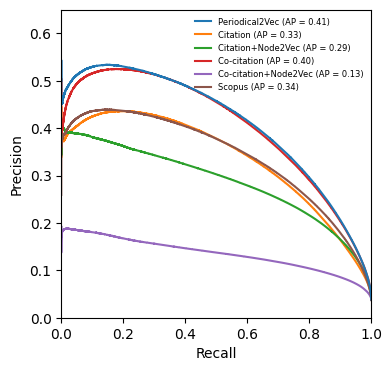

In [57]:
with open('/home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/pr_results.pkl', 'rb') as f:
    pr_results = pickle.load(f)

fig = plt.figure(figsize=(4,4))

for label, results in pr_results.items():
    for recall, precision, macro_ap in results:
        if label == 'kmeans_label':
            z_order = 1
        else :
            z_order = 0
        plt.plot(recall, precision, label=f"{classifier.label_to_method[label]} (AP = {macro_ap:.2f})", zorder=z_order)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, .65])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right', fontsize=6, frameon=False)

plt.show()

In [ ]:
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/doc_classificcation/pr_curve.pdf', dpi=300, bbox_inches='tight')

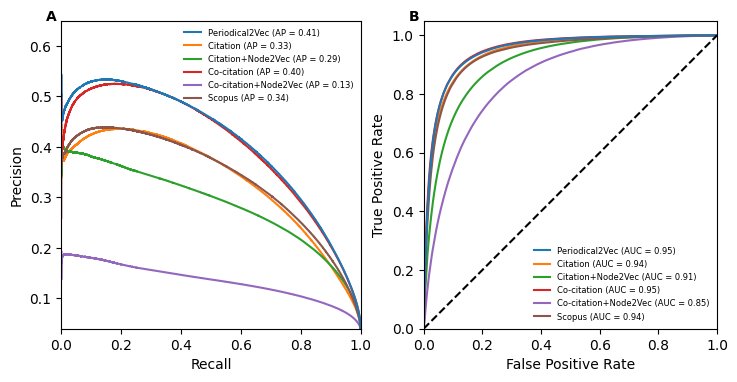

In [58]:
with open('periodical-clustering/data/2010s/classification_tasks/roc_results.pkl', 'rb') as f:
    roc_results = pickle.load(f)
with open('periodical-clustering/data/2010s/classification_tasks/pr_results.pkl', 'rb') as f:
    pr_results = pickle.load(f)

fig = plt.figure(figsize=(8.5,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for label, results in pr_results.items():
    for recall, precision, macro_ap in results:
        if label == 'kmeans_label':
            z_order = 1
        else :
            z_order = 0
        if label != 'scopus_label':
            ax1.plot(recall, precision, label=f"{classifier.label_to_method[label]} (AP = {macro_ap:.2f})", zorder=z_order)
        else:
            ax1.plot(recall, precision, label=f"Scopus (AP = {macro_ap:.2f})", zorder=z_order)
# ax1.set_aspect('equal')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.04, .65])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend(loc='upper right', fontsize=6, frameon=False)
ax1.text(-0.05, .65, 'A', weight='bold')

for label, results in roc_results.items():
    for fpr, tpr, auc_score in results:
        if label == 'kmeans_label':
            z_order = 1
        else :
            z_order = 0
        if label != 'scopus_label':
            ax2.plot(fpr, tpr, label=f"{classifier.label_to_method[label]} (AUC = {auc_score:.2f})", zorder=z_order)
        else:
            ax2.plot(fpr, tpr, label=f"Scopus (AUC = {auc_score:.2f})", zorder=z_order)
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_aspect('equal')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc='lower right', fontsize=6, frameon=False)
ax2.text(-0.05, 1.05, 'B', weight='bold')

plt.show()

In [59]:
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/doc_classification/PR_&_ROC_curve.pdf', dpi=300, bbox_inches='tight')